# 2. Borehole heat transfer
The representation of the heat extraction rate along a borehole using basis functions is compared to a reference solution and to a finite difference model.

In [1]:
# Import necessary packages
import geothermsim as gs

from jax import numpy as jnp
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import roots_legendre

## 2.1. Dimensions and thermal properties of the borehole
A straight vertical borehole located at the origin (x=0, y=0) is used since the model is only dependent on the longitudinal position along the borehole.

In [2]:
L = 150.      # Borehole length (in meters)
D = 4.        # Borehole buried depth (in meters)
r_b = 0.075   # Borehole radius (in meters)
x = 0.        # Borehole position x on the horizontal plane (in meters)
y = 0.        # Borehole position y on the horizontal plane (in meters)

The fluid is propylene-glycol (20%) and the internal thermal resistances were calculated for a typical borehole configuration using the multipole method.

In [3]:
m_flow = 0.1      # Fluid mass flow rate (in kg/s)
cp_f = 3976.8     # Fluid specific heat capacity (in J/kg-K)

# Delta-circuit thermal resistances (in m-K/W)
R_d = jnp.array(
    [[0.4, -10.],
     [-10., 0.4]])

## 2.2. Reference solution
The reference solution is evaluated at $51$ coordinates corresponding to the gauss-legendre quadrature nodes.

In [4]:
n_eval = 51
xi, w = roots_legendre(n_eval)
xi = jnp.array(xi)
w = jnp.array(w)

The borehole wall temperature along the borehole is given by:
$$
T_b(\xi) = 1 + \xi^{(N-1)}
$$
where $T_b(\xi)$ is in $[\degree \text{C}]$ and $N$ is the number of nodes per segment in the borehole discretization, and the inlet fluid temperature is $T_{f,in}=-1\degree \text{C}$.

The exponent power $N-1$ guarantees that the borehole wall temperature can be represented by the basis functions, and thus the comparison of the heat extraction rate is not affected by the representation of the borehole wall temperature.

The reference solution is evaluated at a time for values of $N$ ranging from 1 to 11.

In [5]:
N = 11
T_f_in = -1.
f_T_b = lambda _eta, _N: 1. + _eta**(_N - 1)

In [6]:
q_ref = []
for _N in range(1, N + 1):
    basis = gs.Basis.Legendre(_N)
    borehole = gs.SingleUTube.from_dimensions(R_d, L, D, r_b, x, y, basis, 1)
    T_b_nodes = f_T_b(borehole.xi, _N)
    q_ref.append(borehole.heat_extraction_rate(xi, T_f_in, T_b_nodes, m_flow, cp_f))
q_ref = jnp.stack(q_ref, axis=1)

## 2.3. Solution using geothermsim
The solution is also evaluated using geothermsim for the same values of $N$ ranging from 1 to 11 and for numbers of segments $S$ ranging from 1 to 5.

In [7]:
S = 5
q_nodes = []
q_model = []
boreholes = []
for _S in range(1, S + 1):
    for _N in range(1, N + 1):
        basis = gs.Basis.Legendre(_N)
        borehole = gs.SingleUTube.from_dimensions(R_d, L, D, r_b, x, y, basis, _S)
        boreholes.append(borehole)
        T_b_nodes = f_T_b(borehole.xi, _N)
        q_nodes.append(borehole.heat_extraction_rate_to_self(T_f_in, T_b_nodes, m_flow, cp_f))
        q_model.append(borehole.f(xi, q_nodes[-1]))
q_model = jnp.concatenate(q_model).reshape(S, N, n_eval).T

## 2.4. Comparison between the reference and geothermsim solutions
The heat extraction rate profile is compared to the reference for $S=5$ and $N=11$.

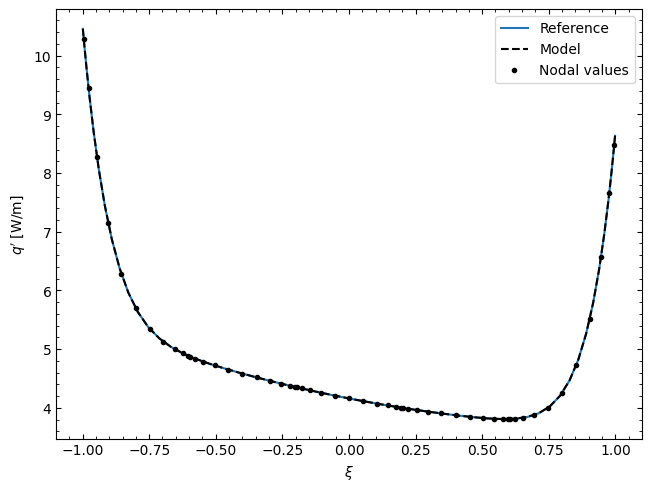

In [8]:
# Plot heat extraction rate
fig, ax = plt.subplots(layout='constrained')
gs.plot._format_axis(ax, axis_labels=[r'$\xi$', r'$q^\prime$ [W/m]'])
ax.plot(xi, q_ref[:, -1], label='Reference');
ax.plot(xi, q_model[:, -1, -1], 'k--', label='Model');
ax.plot(boreholes[-1].xi, q_nodes[-1], 'k.', label='Nodal values');
ax.legend();

The mean absolute percentage error (MAPE) between the reference borehole wall temperature and that evaluated by the interpolation of the model using the basis functions is given by:
$$
MAPE = \frac{1}{2} \int_{-1}^{1} \left| \frac{q^\prime_{reference}(\xi) - q^\prime_{model}(\xi)}{q^\prime_{reference}(\xi)} \right| d\xi \cdot 100 \%
$$

In [9]:
mape = ((jnp.abs((q_ref.T - q_model.T)) / q_ref.T) @ w * 100).T

In [10]:
# Format and print dataframe
df_mape = pd.DataFrame(
    mape,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S + 1)],
    index=jnp.arange(1, N + 1))
df_mape.index.name = 'N'
df_mape.style.set_caption('Mean Absolute Percentage Error (MAPE) [%]') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,17.938812,8.644916,6.014106,4.275633,3.606827
2,7.100760,1.453674,0.603351,0.340029,0.209285
3,0.237535,0.117130,0.029299,0.013384,0.006320
4,0.111548,0.027280,0.005493,0.001785,0.000672
5,0.022597,0.004596,0.000474,0.000127,0.000050
6,0.012894,0.001123,0.000134,0.000076,0.000076
7,0.003146,0.000231,0.000127,0.000124,0.000128
8,0.001759,0.000230,0.000261,0.000236,0.000233
9,0.000871,0.001426,0.001427,0.001418,0.001354


The root mean square error (RMSE) can also be evaluated:
$$
RMSE = \sqrt{\frac{1}{2} \int_{-1}^{1} \left[ q^\prime_{reference}(\xi) - q^\prime_{model}(\xi) \right]^2 d\xi}
$$

In [11]:
rmse = jnp.sqrt((q_ref.T - q_model.T)**2 @ w).T

In [12]:
# Format and print dataframe
df_rmse = pd.DataFrame(
    rmse,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S + 1)],
    index=jnp.arange(1, N + 1))
df_rmse.index.name = 'N'
df_rmse.style.set_caption(r'Root Mean Square Error (RMSE) $[W/m]$') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,1.136609,0.590064,0.411510,0.300760,0.247363
2,0.190090,0.051739,0.023082,0.013202,0.008229
3,0.015854,0.005155,0.001627,0.000698,0.000346
4,0.004007,0.000828,0.000184,0.000058,0.000023
5,0.001322,0.000187,0.000024,0.000006,0.000002
6,0.000472,0.000036,0.000005,0.000003,0.000003
7,0.000178,0.000010,0.000006,0.000006,0.000006
8,0.000068,0.000008,0.000009,0.000009,0.000009
9,0.000038,0.000052,0.000055,0.000055,0.000054


## 2.5. Finite difference solution
A finite difference model is used for validation of the geothermsim solution. The finite difference model uses $101$ evenly spaced longitudinal positions $s_i$ along the length of each pipe. The finite difference model solves the system of differential equations:
$$
\begin{align}
\dot{m}_f c_{p,f} \frac{dT_{f,1}}{ds} &= \frac{T_b(s) - T_{f,1}(s)}{R_{11}^\Delta} + \frac{T_{f,2}(s) - T_{f,1}(s)}{R_{12}^\Delta} \\
-\dot{m}_f c_{p,f} \frac{dT_{f,2}}{ds} &= \frac{T_b(s) - T_{f,2}(s)}{R_{22}^\Delta} + \frac{T_{f,1}(s) - T_{f,2}(s)}{R_{21}^\Delta} \\
\end{align}
$$
where $\dot{m}_f$ is the fluid mass flow rate, $c_{p,f}$ is the fluid specific heat capacity, $R_{ij}^\Delta$ are the delta-circuit thermal resistances, 
$T_{f,1}(s)$ and $T_{f,2}(s)$ are the fluid temperatures in the downward and upward flowing pipes at a longitudinal position $s$ and $T_b(s)$ is the borehole wall temeprature.

In discrete form:
$$
\begin{align}
\dot{m}_f c_{p,f} \frac{T_{f,1}(s_i) - T_{f,1}(s_{i-1})}{s_i - s_{i-1}} &= \frac{T_b(\frac{s_i + s_{i-1}}{2}) - \frac{1}{2} T_{f,1}(s_i) - \frac{1}{2} T_{f,1}(s_{i-1})}{R_{11}^\Delta} + \frac{\frac{1}{2} T_{f,2}(s_i) + \frac{1}{2} T_{f,2}(s_{i-1}) - \frac{1}{2} T_{f,1}(s_i) - \frac{1}{2} T_{f,1}(s_{i-1})}{R_{12}^\Delta} \\
-\dot{m}_f c_{p,f} \frac{T_{f,2}(s_i) - T_{f,2}(s_{i-1})}{s_i - s_{i-1}} &= \frac{T_b(\frac{s_i + s_{i-1}}{2}) - \frac{1}{2} T_{f,2}(s_i) - \frac{1}{2} T_{f,2}(s_{i-1})}{R_{22}^\Delta} + \frac{\frac{1}{2} T_{f,1}(s_i) + \frac{1}{2} T_{f,1}(s_{i-1}) - \frac{1}{2} T_{f,2}(s_i) - \frac{1}{2} T_{f,2}(s_{i-1})}{R_{21}^\Delta} \\
\end{align}
$$

In [13]:
class FiniteDifferenceSingleUTube:

    def __init__(self, R_d, L, num=101):
        self.R_d = R_d
        self.L = L
        self.num = num
        self.s = jnp.linspace(0., L, num=num)

    def solve(self, T_f_in, f_T_b, m_flow, cp_f):
        A = self.system_of_equations(m_flow, cp_f)
        B = self.boundary_condition(T_f_in, f_T_b, m_flow, cp_f)
        X = jnp.linalg.solve(A, B)
        T_f = X.reshape(-1, 2, order='F')
        xi = jnp.linspace(-1., 1., num=self.num)
        T_b = f_T_b(xi)
        R_b = self.R_d[0, 0] * self.R_d[1, 1] / (self.R_d[0, 0] + self.R_d[1, 1])
        q = T_b / R_b - T_f[:, 0] / self.R_d[0, 0] - T_f[:, 1] / self.R_d[1, 1]
        return q, T_f

    def boundary_condition(self, T_f_in, f_T_b, m_flow, cp_f):
        xi = jnp.linspace(-1., 1., num=self.num)
        xi = 0.5 * (xi[:-1] + xi[1:])
        T_b = f_T_b(xi)
        ds = self.L / (self.num - 1.)
        beta_1 = 1. / (m_flow * cp_f * self.R_d[0, 0])
        beta_12 = 1. / (m_flow * cp_f * self.R_d[0, 1])
        beta_2 = 1. / (m_flow * cp_f * self.R_d[1, 1])
        B = jnp.concatenate([jnp.array([T_f_in]), ds * beta_1 * T_b, ds * beta_2 * T_b, jnp.zeros(1)])     
        return B

    def system_of_equations(self, m_flow, cp_f):
        ds = self.L / (self.num - 1.)
        beta_1 = 1. / (m_flow * cp_f * self.R_d[0, 0])
        beta_12 = 1. / (m_flow * cp_f * self.R_d[0, 1])
        beta_2 = 1. / (m_flow * cp_f * self.R_d[1, 1])
        N = self.num - 1
        A_11 = (1. + 0.5 * ds * (beta_1 + beta_12)) * jnp.eye(N, M=N+1, k=1)
        A_11 = A_11 + (-1. + 0.5 * ds * (beta_1 + beta_12)) * jnp.eye(N, M=N+1, k=0)
        A_12 = -0.5 * ds * beta_12 * jnp.eye(N, M=N+1, k=1)
        A_12 = A_12 - 0.5 * ds * beta_12 * jnp.eye(N, M=N+1, k=0)
        A_21 = -0.5 * ds * beta_12 * jnp.eye(N, M=N+1)
        A_21 = A_21 - 0.5 * ds * beta_12 * jnp.eye(N, M=N+1, k=1)
        A_22 = (1. + 0.5 * ds * (beta_1 + beta_12)) * jnp.eye(N, M=N+1)
        A_22 = A_22 + (-1. + 0.5 * ds * (beta_1 + beta_12)) * jnp.eye(N, M=N+1, k=1)
        A = jnp.block(
            [[jnp.eye(1), jnp.zeros((1, 2 * N + 1))],
             [A_11, A_12],
             [A_21, A_22],
             [jnp.zeros((1, N)), -jnp.eye(1), jnp.zeros((1, N)), jnp.eye(1)]]
        )
        return A

In [14]:
n_eval = 101
xi = jnp.linspace(-1., 1., num=n_eval)
borehole_FD = FiniteDifferenceSingleUTube(R_d, L, num=n_eval)

In [15]:
q_FD = []
T_f_FD = []
for _N in range(1, N + 1):
    f_T_b_N = lambda _eta: f_T_b(_eta, _N)
    q_FD_N, T_f_FD_N = borehole_FD.solve(T_f_in, f_T_b_N, m_flow, cp_f)
    q_FD.append(q_FD_N)
    T_f_FD.append(T_f_FD_N)
q_FD = jnp.stack(q_FD, axis=1)
T_f_FD = jnp.stack(T_f_FD, axis=1)

The model is evaluated at the same longitudinal positions.

In [16]:
S = 5
N = 11
q_nodes = []
q_model = []
T_f_model = []
T_b_nodes = []
boreholes = []
for _S in range(1, S + 1):
    for _N in range(1, N + 1):
        basis = gs.Basis.Legendre(_N)
        borehole = gs.SingleUTube.from_dimensions(R_d, L, D, r_b, x, y, basis, _S)
        boreholes.append(borehole)
        T_b_nodes.append(f_T_b(borehole.xi, _N))
        q_nodes.append(borehole.heat_extraction_rate_to_self(T_f_in, T_b_nodes[-1], m_flow, cp_f))
        q_model.append(borehole.f(xi, q_nodes[-1]))
        T_f_model.append(borehole.fluid_temperature(xi, T_f_in, T_b_nodes[-1], m_flow, cp_f))
q_model = jnp.concatenate(q_model).reshape(S, N, n_eval).T
T_f_model = jnp.concatenate(T_f_model).reshape(S, N, n_eval, 2).T

## 2.6. Comparison between the finite difference and model solutions
The heat extraction rate profile is compared to the finite difference solution for $S=5$ and $N=11$.

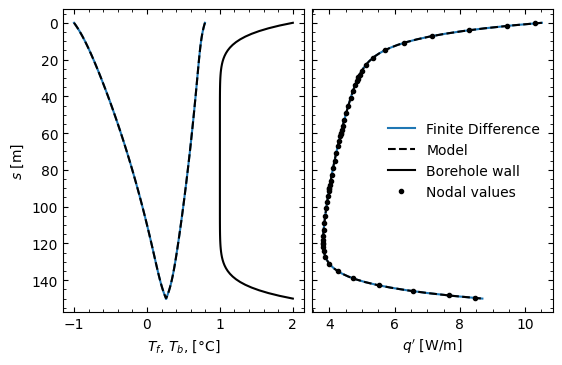

In [17]:
# Plot fluid temperature, borehole wall temperature and heat extraction rate profiles
fig, axs = plt.subplots(ncols=2, sharey=True, layout='constrained')

s = boreholes[-1].path.f_s(xi)

# Temperatures
gs.plot._format_axis(axs[0], axis_labels=[r'$T_f$, $T_b$, $[\degree \text{C}]$', r'$s$ [m]'], inverse_y=True)
line = axs[0].plot(T_f_FD[:, -1, 0], s, label='Finite Difference');
axs[0].plot(T_f_FD[:, -1, 1], s, c=line[0].get_color());
axs[0].plot(T_f_model[0, :, -1, -1], s, 'k--', label='Model');
axs[0].plot(T_f_model[1, :, -1, -1], s, 'k--');
axs[0].plot(boreholes[-1].f(xi, T_b_nodes[-1]), s, 'k-', label='Borehole wall');
# axs[0].legend(frameon=False);

# Heat extraction rates
gs.plot._format_axis(axs[1])
axs[1].set_xlabel(r'$q^\prime$ [W/m]')
axs[1].plot(q_FD[:, -1], s, label='Finite Difference');
axs[1].plot(q_model[:, -1, -1], s, 'k--', label='Model');
axs[1].plot(jnp.nan, jnp.nan, 'k-', label='Borehole wall');
axs[1].plot(q_nodes[-1], boreholes[-1].s, 'k.', label='Nodal values');
axs[1].legend(frameon=False);

# plt.tight_layout()
fig.set_size_inches(140. / 25.4, 90. / 25.4)
fig.savefig('borehole-heat-transfer.eps')

In [18]:
mape_T = jnp.mean(jnp.mean(jnp.abs((jnp.moveaxis(T_f_FD, -1, 0).T - T_f_model.T) / (T_f_FD[0, :, 1] - T_f_FD[0, :, 0]).T[..., jnp.newaxis, jnp.newaxis]), axis=-1), axis=-1).T * 100
mape_q = jnp.mean(jnp.abs(q_FD.T - q_model.T) / q_FD.T, axis=-1).T * 100

In [19]:
# Format and print dataframe
segments = [f'S = {_S}' for _S in jnp.arange(1, S + 1)]
variable = ['Fluid temperatures', 'Heat extraction rates']

df_mape = pd.DataFrame(
    jnp.concatenate((mape_T, mape_q), axis=-1),
    columns=pd.MultiIndex.from_product([variable, segments]),
    index=jnp.arange(1, N + 1))
df_mape.index.name = 'N'
df_mape.style.set_caption('Mean Absolute Percentage Error (MAPE) [%]') 

In [20]:
rmse_T = jnp.sqrt(jnp.mean(jnp.mean((jnp.moveaxis(T_f_FD, -1, 0).T - T_f_model.T)**2, axis=-1), axis=-1).T)
rmse_q = jnp.sqrt(jnp.mean((q_FD.T - q_model.T)**2, axis=-1).T)

In [21]:
# Format and print dataframe
segments = [f'S = {_S}' for _S in jnp.arange(1, S + 1)]
variable = [r'Fluid temperatures $[\degree \text{C}]$', r'Heat extraction rates [W/m]']

df_mape = pd.DataFrame(
    jnp.concatenate((rmse_T, rmse_q), axis=-1),
    columns=pd.MultiIndex.from_product([variable, segments]),
    index=jnp.arange(1, N + 1))
df_mape.index.name = 'N'
df_mape.style.set_caption('Root Mean Square Error (RMSE)') 